In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

OUTPUT_PATH = "./out/"
OUTPUT_PATH_F = "./figures/"

raycasts = ["IFRC", "FRC","HRC", "EFRC"]

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

# Pointer

In [2]:
dfPointer = pd.read_pickle(OUTPUT_PATH + "data_v03_PointerOnly.pkl")
raycasts = ["IFRC", "FRC","HRC", "EFRC"]
for rc in raycasts:
    dfPointer[rc+"Angle"] = dfPointer["Intersection"+ rc].apply(lambda x: math.degrees(math.atan2(x[0],x[2])))
    dfPointer[rc+"X"]  = (dfPointer[rc + "Angle"] / 180.0) * np.pi * 4.0
    dfPointer[rc+"Y"]  = dfPointer["Intersection"+ rc].apply(lambda x: x[1])
    dfPointer[rc+"XCorected"] = dfPointer[["TargetProjectionX", rc+"X"]].apply(lambda x:  x[rc+"X"] - 4*np.pi*2 if x[rc+"X"] - x.TargetProjectionX > 4*np.pi else x[rc+"X"] ,axis=1)
    
    
    
    dfPointer[rc+"Error"] = np.sqrt(np.power(dfPointer.TargetProjectionX-dfPointer[rc+"XCorected"], 2) + 
                        np.power(dfPointer.TargetProjectionY-dfPointer[rc+"Y"], 2))
len(dfPointer)

3360

In [3]:
lst = []
for rc in raycasts:
    lst.append(rc+"DistanceError")
dfPointerFilter = dfPointer[lst].describe()

beforelen = len(dfPointer)*4

dfDic = []
for rc in raycasts:
    #df = dfPointer.copy(deep=True)
    df = dfPointer[dfPointer[rc+"DistanceError"] < dfPointerFilter[rc+"DistanceError"]["mean"] + 3 * dfPointerFilter[rc+"DistanceError"]["std"]].copy(deep=True)
    for rc_loop in raycasts:
        if (rc != rc_loop):
            del df[rc_loop+"X"]
            del df[rc_loop+"XCorected"]
            del df[rc_loop+"Y"]
            del df[rc_loop+"Angle"]
            del df[rc_loop+"DistanceError"]
    df["RayCasts"] = rc
    df = df.rename(columns={rc+"X":'X',
                            rc+"XCorected":'XCorected',
                            rc+"Y":"Y",
                            rc+"Angle":"Angle",
                            rc+"DistanceError": 'DistanceError'})
    dfDic.append(df)

df = pd.concat(dfDic)

print("Filterd: %.2f"%(100-(len(df) / beforelen)*100))

Filterd: 0.42


IFRC


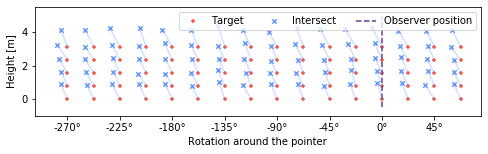

FRC


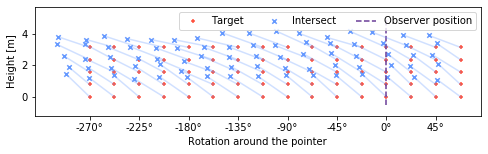

HRC


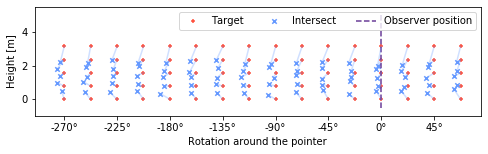

EFRC


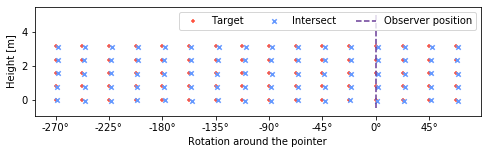

In [4]:
for rc in raycasts:
    plt.figure(figsize=(8,2))
    print(rc)
        
    dfAgg = df[df.RayCasts == rc].groupby(["TargetId", "PId"]).mean().groupby(["TargetId"]).median()
    dfAgg = dfAgg.reset_index()
    
    plt.scatter(dfAgg.TargetProjectionX, dfAgg.TargetProjectionY, marker="+", s=20, color=colorDic["red"], label="Target")
    plt.scatter(dfAgg["XCorected"], dfAgg["Y"], marker="x", s=20, color=colorDic["blue"], label="Intersect")
    ax = plt.gca()
    for i, e in dfAgg.iterrows():
        l = mlines.Line2D([e.TargetProjectionX, e["XCorected"]], [e.TargetProjectionY, e["Y"]], color=colorDic["blue"], alpha=0.3)
        ax.add_line(l)

    plt.vlines((4*np.pi*2) /360 * 90, ymin=-.5, ymax=5, linestyles="--", color=colorDic["purple"], label="Observer position")    
    lstTicks = []
    for x in np.arange(-180-90,181-90,45):
        lstTicks.append(str(x)+"°")
    plt.xticks((4*np.pi*2)/360 * np.arange(-180,181,45), lstTicks)

    plt.ylabel("Height [m]")
    plt.xlabel("Rotation around the pointer")
    plt.legend(ncol=3, loc=1)
    plt.axis('equal')
    plt.savefig('%sS1_Pointer%s.pdf' % (OUTPUT_PATH_F, rc), bbox_inches='tight',transparent=False, pad_inches=0)
    plt.show()

In [5]:
df.groupby(["RayCasts", "PId"]).mean().reset_index().groupby(["RayCasts"])['DistanceError'].median().round(3)*100.0

RayCasts
EFRC     38.2
FRC     524.6
HRC     169.1
IFRC    239.1
Name: DistanceError, dtype: float64

In [6]:
df.groupby(["RayCasts", "PId"]).mean().reset_index().groupby(["RayCasts"])['DistanceError'].describe().round(3)*100.0

,count,mean,std,min,25%,50%,75%,max
RayCasts,,,,,,,,
EFRC,1400.0,40.0,8.5,26.9,36.4,38.2,44.3,56.9
FRC,1400.0,498.4,83.1,369.8,431.2,524.6,550.0,635.8
HRC,1400.0,172.7,53.0,108.3,130.6,169.1,200.3,277.2
IFRC,1400.0,284.1,175.0,102.0,166.7,239.1,302.0,699.5


In [7]:
lst = ["RayCasts", "PId", 'DistanceError']
df.groupby(["RayCasts", "PId"]).mean().reset_index()[lst].to_csv(OUTPUT_PATH + "R_Distance_Pointer.csv", index=None)

# Observer

In [8]:
dfObserver = pd.read_pickle(OUTPUT_PATH + "data_v03_ObserverOnly.pkl")
print(len(dfObserver))

dfObserver["StickAngle"] = dfObserver.IntersectionStick.apply(lambda x: math.degrees(math.atan2(x[0],x[2])))
dfObserver["StickX"]  = (dfObserver.StickAngle / 180.0) * np.pi * 4.0
dfObserver["StickY"]  = dfObserver.IntersectionStick.apply(lambda x: x[1])
dfObserver['StickXCorected'] =dfObserver[["TargetProjectionX", "StickX"]].apply(lambda x:  x.StickX - 4*np.pi*2 if x.StickX - x.TargetProjectionX > 4*np.pi else x.StickX ,axis=1)
dfObserver["StickError"] = np.sqrt(np.power(dfObserver.StickXCorected - dfObserver.TargetProjectionX, 2) + np.power(dfObserver.StickY - dfObserver.TargetProjectionY, 2))

des = dfObserver["StickError"].describe()
des
x = len(dfObserver)
dfObserver = dfObserver[dfObserver.StickError < des["mean"] + 3*des["std"]]
print("Filterd: %.2f"%(100-(len(dfObserver) / x)*100))

lst = ["ObserverDistance", "TargetProjectionX", "TargetProjectionY", "PId", 'StickError']
dfObserver.groupby(["ObserverDistance", "TargetProjectionX", "TargetProjectionY", "PId"]).mean().reset_index()[lst].to_csv(OUTPUT_PATH + "R_Distance_Observer.csv", index=None)

3360
Filterd: 0.48


0 1
1 2


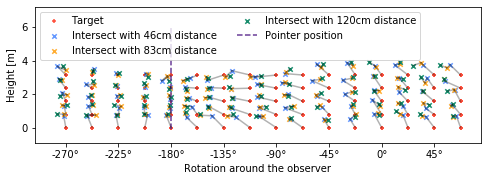

In [9]:
dfAgg = dfObserver.groupby(["ObserverDistance", "TargetId"])[["StickXCorected", "StickY", "TargetProjectionX", "TargetProjectionY"]].median()
dfAgg = dfAgg.reset_index()
plt.figure(figsize=(8,2.5))
plt.scatter(df.TargetProjectionX, df.TargetProjectionY, marker="+", s=20, color=colorDic["red"], label="Target")
lst = sorted(dfAgg.ObserverDistance.unique())
for dis in lst:
    df = dfAgg[dfAgg.ObserverDistance == dis]
    
    s = ""
    if (dis == 0):
        s = s + "46cm"
        c = colorDic["blue"]
    elif (dis == 1):
        s = s + "83cm"
        c = colorDic["yellow"]
    elif (dis == 2):
        s = s + "120cm"
        c = colorDic["green"]
    
    plt.scatter(df.StickXCorected, df.StickY, marker="x", s=20, color=c, label="Intersect with " + s + " distance")

    #av = dfMatch[['TargetProjectionX', 'StickX', 'TargetProjectionY', 'StickY']].values
    ax = plt.gca()
    if  (dis == 0):
        for i, e in df.iterrows():
            l = mlines.Line2D([e.TargetProjectionX, e.StickXCorected], [e.TargetProjectionY, e.StickY], color='k', alpha=0.3)
            ax.add_line(l)
    else:
        print(dis-1, dis)
        df2 = dfAgg[dfAgg.ObserverDistance == dis-1]
        for tid in df2.TargetId.values:
            e1 = df[df.TargetId == tid].iloc[0]
            e2 = df2[df2.TargetId == tid].iloc[0]
            l = mlines.Line2D([e1.StickXCorected, e2.StickXCorected], [e1.StickY, e2.StickY], color='k', alpha=0.3)
            ax.add_line(l)
        

plt.vlines((4*np.pi*2) /360 * -90, ymin=-.1, ymax=6, linestyles="--", color=colorDic["purple"], label="Pointer position")
plt.ylim(-3,5)

lstTicks = []
for x in np.arange(-180-90,181-90,45):
    lstTicks.append(str(x)+"°")
plt.xticks((4*np.pi*2)/360 * np.arange(-180,181,45), lstTicks)


plt.ylabel("Height [m]")
plt.xlabel("Rotation around the observer")
plt.legend(ncol=2, loc=2)
plt.axis('equal')

plt.ylim(0,)
plt.savefig('%sS1_Observer.pdf' % (OUTPUT_PATH_F), bbox_inches='tight',transparent=False, pad_inches=0)
plt.show()

In [10]:
(dfObserver.groupby(["ObserverDistance", "PId"]).mean().reset_index().groupby(["ObserverDistance"])['StickError']).describe().round(3)*100.0

,count,mean,std,min,25%,50%,75%,max
ObserverDistance,,,,,,,,
0,1400.0,96.8,24.8,49.2,79.5,100.7,111.6,134.1
1,1400.0,103.1,27.3,47.9,88.2,104.4,124.8,141.3
2,1400.0,102.9,25.4,69.3,78.4,106.3,118.9,148.8
